# What is an Embedding?

In [94]:
from openai import OpenAI

# Initialize OpenAI client
client = OpenAI()

text = "Hello!"

embedding = client.embeddings.create(input=[text], model="text-embedding-3-small").data[0].embedding

print("--- Embedding for 'Hello!' ---\n")
print(embedding[:20], "... 1,516 More Values")
print("\n--- Length ---\n")
print(len(embedding), "Dimensions")

--- Embedding for 'Hello!' ---

[0.015828024595975876, -0.016119517385959625, 0.018772095441818237, 0.008409549482166767, -0.021832764148712158, -0.02173074148595333, -0.023333948105573654, 0.026117699220776558, -0.0011732559651136398, -0.04902898520231247, 0.0033776655327528715, -0.01931135728955269, 0.007753691636025906, -0.026992175728082657, 0.014953549019992352, 0.029513582587242126, -0.05459648370742798, 0.012147936038672924, -0.021687017753720284, 0.061563149094581604] ... 1,516 more values

--- Length ---

1536 Dimensions


In [107]:
df = pd.read_csv('/Users/adamlucek/Documents/Jupyter/VDB/100_embeddings.csv')

df.head(10)

,Word,Category,embedding
0,dog,Animal,"[0.05113774910569191, -0.01870863139629364, -0..."
1,cat,Animal,"[0.025529420003294945, -0.023411665111780167, ..."
2,elephant,Animal,"[0.0468301959335804, -0.036735061556100845, -0..."
3,lion,Animal,"[0.03309255465865135, -0.06823775172233582, 0...."
4,tiger,Animal,"[-0.022506916895508766, -0.044839587062597275,..."
5,giraffe,Animal,"[0.03001997247338295, -0.007419560104608536, -..."
6,zebra,Animal,"[0.03392777219414711, 0.03847114369273186, 0.0..."
7,penguin,Animal,"[0.004724090453237295, -0.045557208359241486, ..."
8,koala,Animal,"[0.0008709794492460787, -0.015873834490776062,..."
9,kangaroo,Animal,"[-0.024211056530475616, -0.005303783807903528,..."


In [110]:
def get_embedding(word):
    """Retrieve the embedding for a given word."""
    try:
        return eval(df[df['Word'] == word]['embedding'].iloc[0])
    except IndexError:
        raise ValueError(f"Word '{word}' not found in the embedding dataset.")

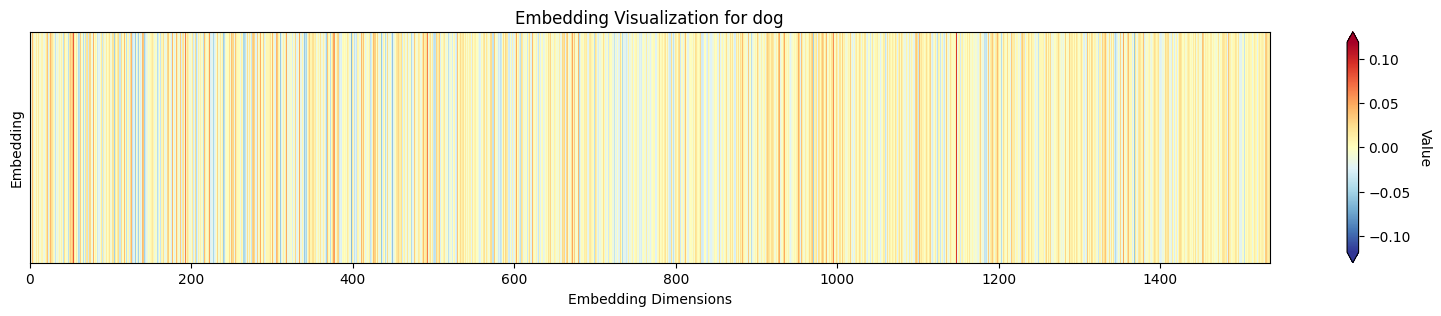

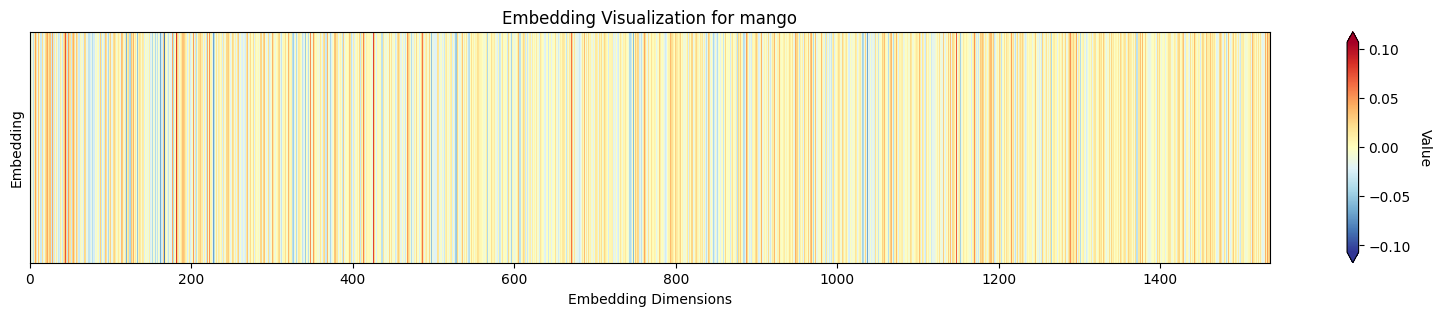

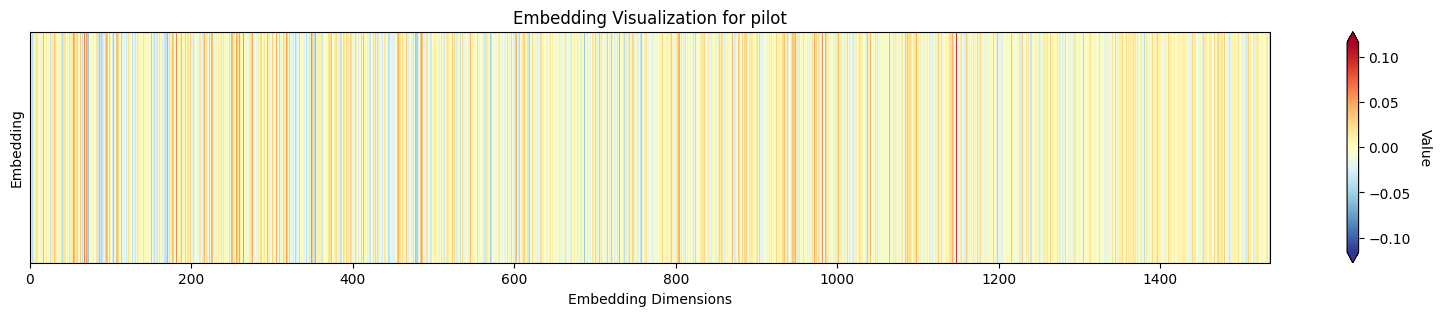

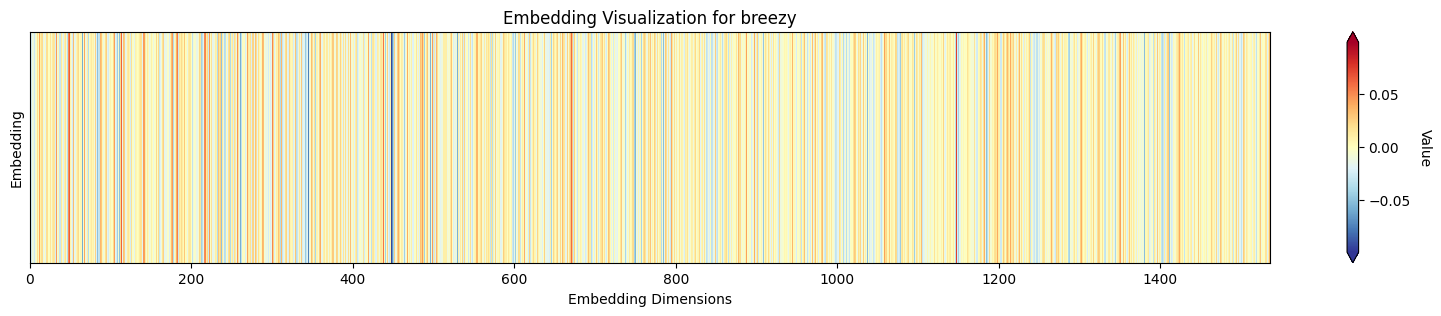

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import TwoSlopeNorm


def visualize_embedding(embedding, title="Embedding Visualization"):
    # Reshape the embedding to a 2D array
    embedding_2d = np.array(embedding).reshape(1, -1)
    
    # Create a diverging colormap centered at zero
    cmap = plt.cm.RdYlBu_r
    vmax = max(abs(np.min(embedding_2d)), abs(np.max(embedding_2d)))
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=(20, 3))
    im = ax.imshow(embedding_2d, aspect='auto', cmap=cmap, norm=norm)
    
    # Set title and labels
    plt.title(title)
    plt.xlabel("Embedding Dimensions")
    plt.ylabel("Embedding")
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, extend='both')
    cbar.set_label('Value', rotation=270, labelpad=15)
    
    # Remove y-axis ticks
    ax.set_yticks([])
    
    # Show every 200th tick on x-axis
    ax.set_xticks(range(0, len(embedding), 200))
    ax.set_xticklabels(range(0, len(embedding), 200))

    plt.show()

visualize_embedding(get_embedding("dog"), "Embedding Visualization for dog")
visualize_embedding(get_embedding("mango"), "Embedding Visualization for mango")
visualize_embedding(get_embedding("pilot"), "Embedding Visualization for pilot")
visualize_embedding(get_embedding("breezy"), "Embedding Visualization for breezy")

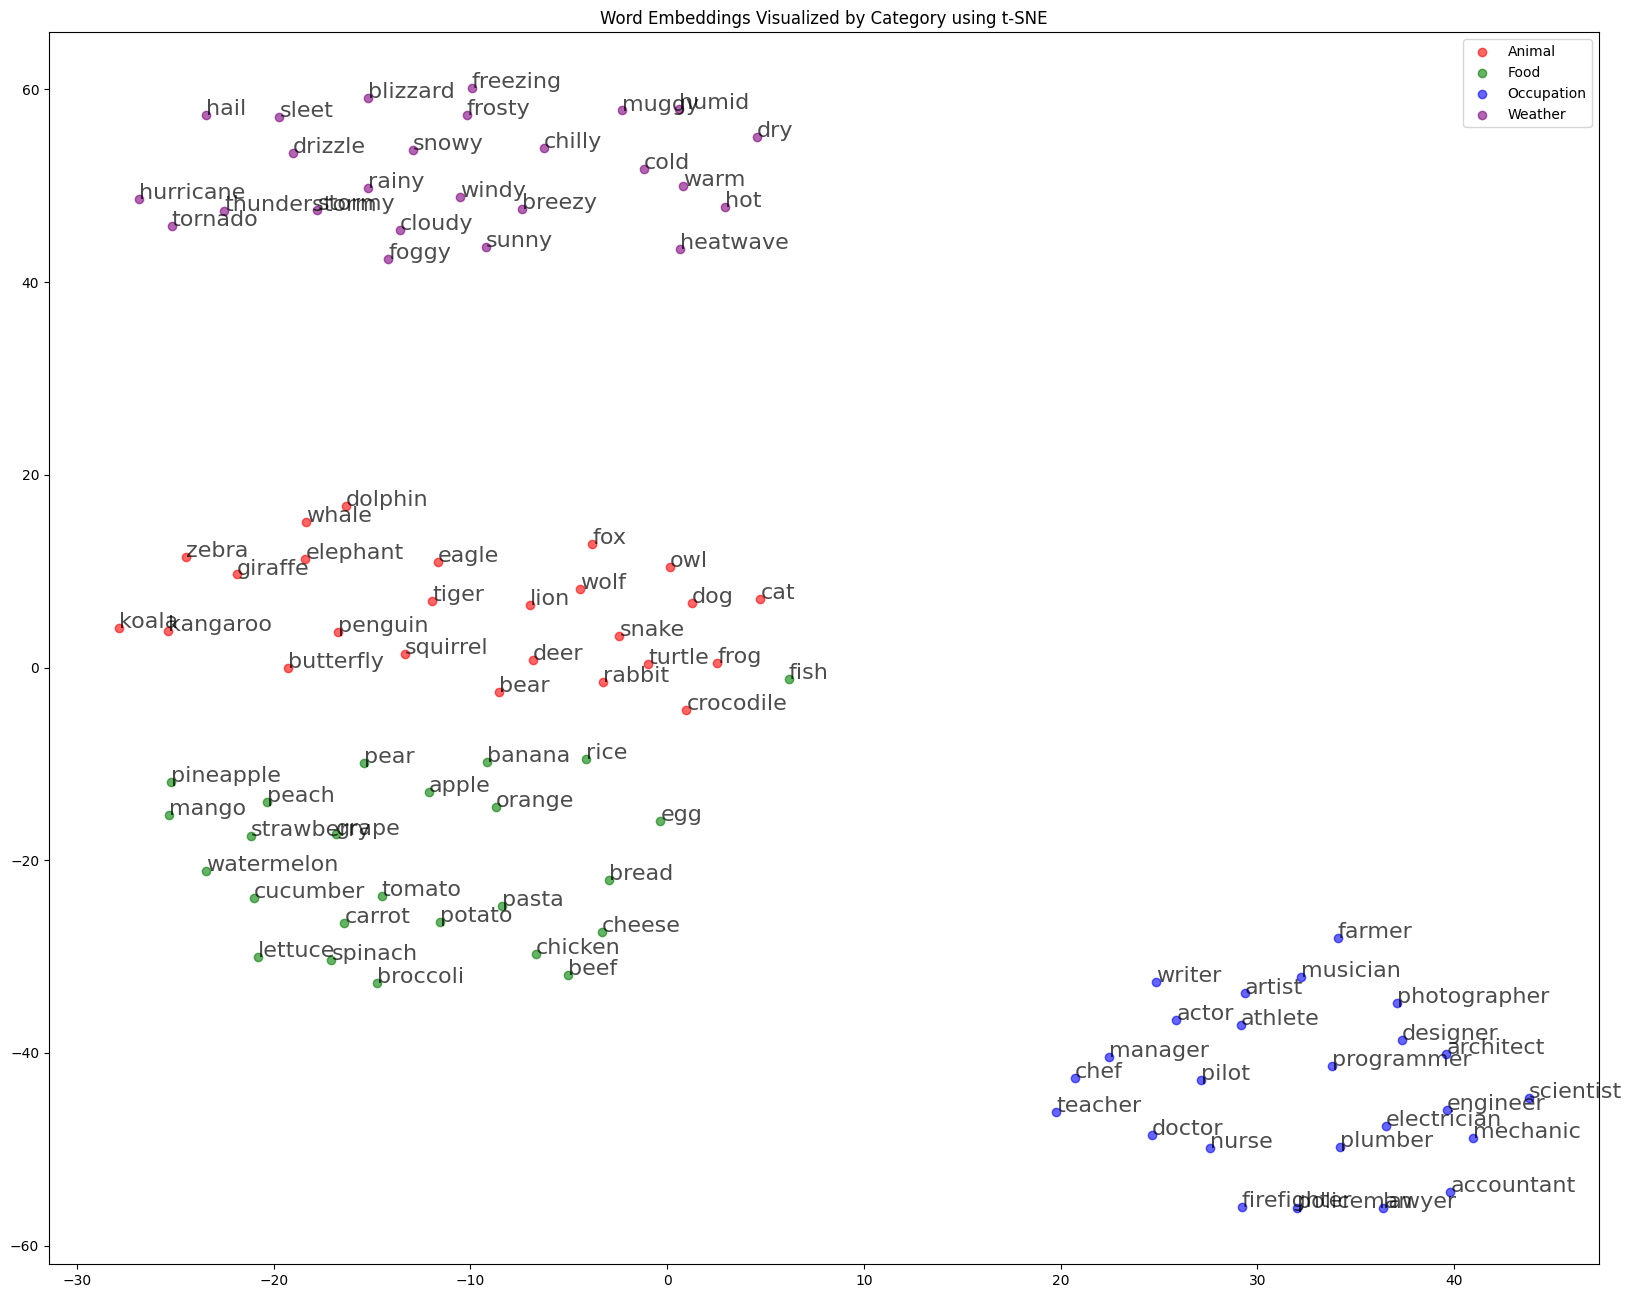

In [21]:
from sklearn.manifold import TSNE

# Convert string representations of lists to numpy arrays
matrix = np.array(df['embedding'].apply(eval).tolist())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

# Define colors for each category
category_colors = {
    'Animal': 'red',
    'Food': 'green',
    'Occupation': 'blue',
    'Weather': 'purple'
}

# Create the scatter plot
plt.figure(figsize=(20, 16))  # Increased figure size for better visibility
for category, color in category_colors.items():
    category_mask = df['Category'] == category
    category_data = vis_dims[category_mask]
    words = df['Word'][category_mask]
    
    plt.scatter(category_data[:, 0], category_data[:, 1], c=color, label=category, alpha=0.6)
    
    # Add labels to each point
    for i, word in enumerate(words):
        plt.annotate(word, (category_data[i, 0], category_data[i, 1]), fontsize=16, alpha=0.7)

plt.title("Word Embeddings Visualized by Category using t-SNE")
plt.legend()
plt.show()

---

# Calculating Similarity

Comparing vector embeddings and determining their similarity is crucial for semantic retrieval. The choice of similarity metric can significantly impact the accuracy of your search results. A key principle is to align the similarity metric of your index with the one used in training your embedding model. For instance, if you're using the [all-MiniLM-L6-v2 model](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2#fine-tuning), which was trained using cosine similarity, employing the same metric in your index will yield the most accurate results.

The concept of "closeness" between vectors is central to understanding semantic relationships. In the context of word embeddings, two vectors may be considered "close" if they represent words used in similar contexts or related to similar ideas. This notion of similarity forms the foundation for the following calculations and their applications in semantic search systems.

### Euclidean Distance

Measures the straight-line distance between two vectors in a vector space. It ranges from 0 to infinity, where 0 represents identical vectors, and larger values represent increasingly dissimilar vectors.

   $\text{Euclidean distance} = \|\mathbf{A} - \mathbf{B}\| = \sqrt{\sum_{i=1}^n (A_i - B_i)^2}$

   Where $\mathbf{A}$ and $\mathbf{B}$ are vectors, and $A_i$ and $B_i$ are their respective components.

**Euclidean Distance in two Dimensions**

<img src="https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2Ffc175963bced347c4984d95d021cbe423d6154db-416x429.png&w=1080&q=75" width=300>

Commonly applied to embeddings when the magnitude of the vectors is meaningful. It measures the straight-line distance between two embedding vectors in the high-dimensional space. In the context of embeddings, a smaller Euclidean distance indicates greater similarity, making it useful for tasks like finding nearest neighbors or clustering similar items.

In [145]:
import math

def euclidean_distance(vec1, vec2):
    """Calculate Euclidean distance between two vectors."""
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(vec1, vec2)))

print("Hot & Cold: ", euclidean_distance(get_embedding("hot"), get_embedding("cold")))
print("Hot & Programmer: ", euclidean_distance(get_embedding("hot"), get_embedding("programmer")))

Hot & Cold:  0.9440164141889588
Hot & Programmer:  1.2950602664127295


### Dot Product:

Measures the product of the magnitudes of two vectors and the cosine of the angle between them. It ranges from -∞ to ∞, where a positive value represents vectors that point in the same direction, 0 represents orthogonal vectors, and a negative value represents vectors that point in opposite directions.

$\mathbf{A} \cdot \mathbf{B} = \sum_{i=1}^n A_i B_i = A_1B_1 + A_2B_2 + \cdots + A_nB_n$

Where $\mathbf{A}$ and $\mathbf{B}$ are vectors, and $A_i$ and $B_i$ are their respective components.

**Dot Product in Two Dimensions**

<img src="https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2Fb2af046e6a6d5d2057f2328171d0bdeba0489a90-338x357.png&w=750&q=75" width=300>

Less commonly used alone for comparing embeddings, the dot product is a fundamental operation in many similarity calculations. For embeddings, it provides a measure of how aligned two vectors are, with higher values indicating greater similarity. It's particularly useful when working with normalized embeddings, as it then effectively captures the cosine similarity. (As seen with OpenAI embeddings, which are normalized)

In [148]:
def dot_product(vec1, vec2):
    """Calculate dot product of two vectors."""
    return sum(a * b for a, b in zip(vec1, vec2))

print("Hot & Cold: ", dot_product(get_embedding("hot"), get_embedding("cold")))
print("Hot & Programmer: ", dot_product(get_embedding("hot"), get_embedding("programmer")))

Hot & Cold:  0.5544164660964531
Hot & Programmer:  0.16140940629592512


### Cosine Similarity:

Measures the cosine of the angle between two vectors in a vector space. It ranges from -1 to 1, where 1 represents identical vectors, 0 represents orthogonal vectors, and -1 represents vectors that are diametrically opposed.

   $\text{cosine similarity} = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|} = \frac{\sum_{i=1}^n A_i B_i}{\sqrt{\sum_{i=1}^n A_i^2} \sqrt{\sum_{i=1}^n B_i^2}}$

   Where $\mathbf{A}$ and $\mathbf{B}$ are vectors, and $A_i$ and $B_i$ are their respective components.

**Cosine Similarity in Two Dimensions**

<img src="https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2F5a5ba7e0971f7b6dc4697732fa8adc59a46b6d8d-338x357.png&w=750&q=75" width=300>

Widely used for comparing embeddings, especially in natural language processing and information retrieval. It measures the cosine of the angle between two embedding vectors, focusing on their orientation rather than magnitude. This makes it particularly useful for comparing embeddings of different lengths or when the relative direction of vectors is more important than their absolute values.

In [149]:
def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors."""
    dot_prod = sum(a * b for a, b in zip(vec1, vec2))
    mag1 = math.sqrt(sum(a ** 2 for a in vec1))
    mag2 = math.sqrt(sum(b ** 2 for b in vec2))
    return dot_prod / (mag1 * mag2) if mag1 * mag2 != 0 else 0

print("Hot & Cold: ", cosine_similarity(get_embedding("hot"), get_embedding("cold")))
print("Hot & Programmer: ", cosine_similarity(get_embedding("hot"), get_embedding("programmer")))

Hot & Cold:  0.5544164875936521
Hot & Programmer:  0.16140941386337487


In [106]:
def compare_words(word1, word2):
    """Compare two words using their embeddings."""
    try:
        embedding1 = get_embedding(word1)
        embedding2 = get_embedding(word2)
        
        euc_dist = euclidean_distance(embedding1, embedding2)
        cos_sim = cosine_similarity(embedding1, embedding2)
        dot_prod = dot_product(embedding1, embedding2)
        
        print(f"Comparison between '{word1}' and '{word2}':")
        print(f"Euclidean Distance: {euc_dist:.4f}")
        print(f"Cosine Similarity: {cos_sim:.4f}")
        print(f"Dot Product: {dot_prod:.4f}")
        print()
    except ValueError as e:
        print(f"Error: {e}")

compare_words("hot", "cold")
compare_words("hot", "warm")

Comparison between 'hot' and 'cold':
Euclidean Distance: 0.9440
Cosine Similarity: 0.5544
Dot Product: 0.5544

Comparison between 'hot' and 'warm':
Euclidean Distance: 0.8565
Cosine Similarity: 0.6332
Dot Product: 0.6332



In [136]:
df2 = pd.read_csv('/Users/adamlucek/Documents/Jupyter/VDB/new_embeddings.csv')

# Concatenate the DataFrames
combined_df = pd.concat([df, df2], ignore_index=True)

In [137]:
combined_df

,Word,Category,embedding
0,dog,Animal,"[0.05113774910569191, -0.01870863139629364, -0..."
1,cat,Animal,"[0.025529420003294945, -0.023411665111780167, ..."
2,elephant,Animal,"[0.0468301959335804, -0.036735061556100845, -0..."
3,lion,Animal,"[0.03309255465865135, -0.06823775172233582, 0...."
4,tiger,Animal,"[-0.022506916895508766, -0.044839587062597275,..."
...,...,...,...
99,muggy,Weather,"[-0.0029042107053101063, 0.006667866837233305,..."
100,parakeet,Animal,"[0.05223187059164047, -0.014343400485813618, -..."
101,cabbage,Food,"[0.03496464341878891, 0.0027530803345143795, 0..."
102,therapist,Occupation,"[-0.011547889560461044, 0.0051359753124415874,..."
